In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import os
import matplotlib.cm as cmaps
import matplotlib.colors as colors
import pickle
import seaborn as sbs
from parse import *
import matplotlib as mpl
import colorcet as cc
import seaborn as sns
from matplotlib import gridspec
import sys
sys.path.append("../SpikeCounter")
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
plt.style.use("../bio_publications.mplstyle")

In [2]:
importlib.reload(utils)
importlib.reload(sc_stats)

<module 'spikecounter.analysis.stats' from '/n/home11/bjia/notebooks/../SpikeCounter/spikecounter/analysis/stats.py'>

In [3]:
datadirs = ["/n/holyscratch01/cohen_lab/bjia/20210420_gcamp_widefield", \
            "/n/holyscratch01/cohen_lab/bjia/20210716_gcamp_widefield", \
           "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield"]
subfolder = "corrected"

In [4]:
figdir = "/n/cohen_lab/Lab/Papers/First Heartbeat/Figures/v8"

In [5]:
f_s = 10.2

### Analyze statistics of temporal dynamics

In [6]:
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(os.path.join(datadir, subfolder, "analysis/all_moments.mat")))

Align all frequencies and CVs from different experiments

In [7]:
unaligned_frequencies = []
unaligned_covs = []
all_index_offsets = []
for i in range(len(expt_moments)):
    moments = expt_moments[i]
    unaligned_frequencies.append(moments["all_freqs"])
    unaligned_covs.append(moments["covs"])
    all_index_offsets.append(moments["idx_offsets"].ravel())
dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

Plot individual frequency moments

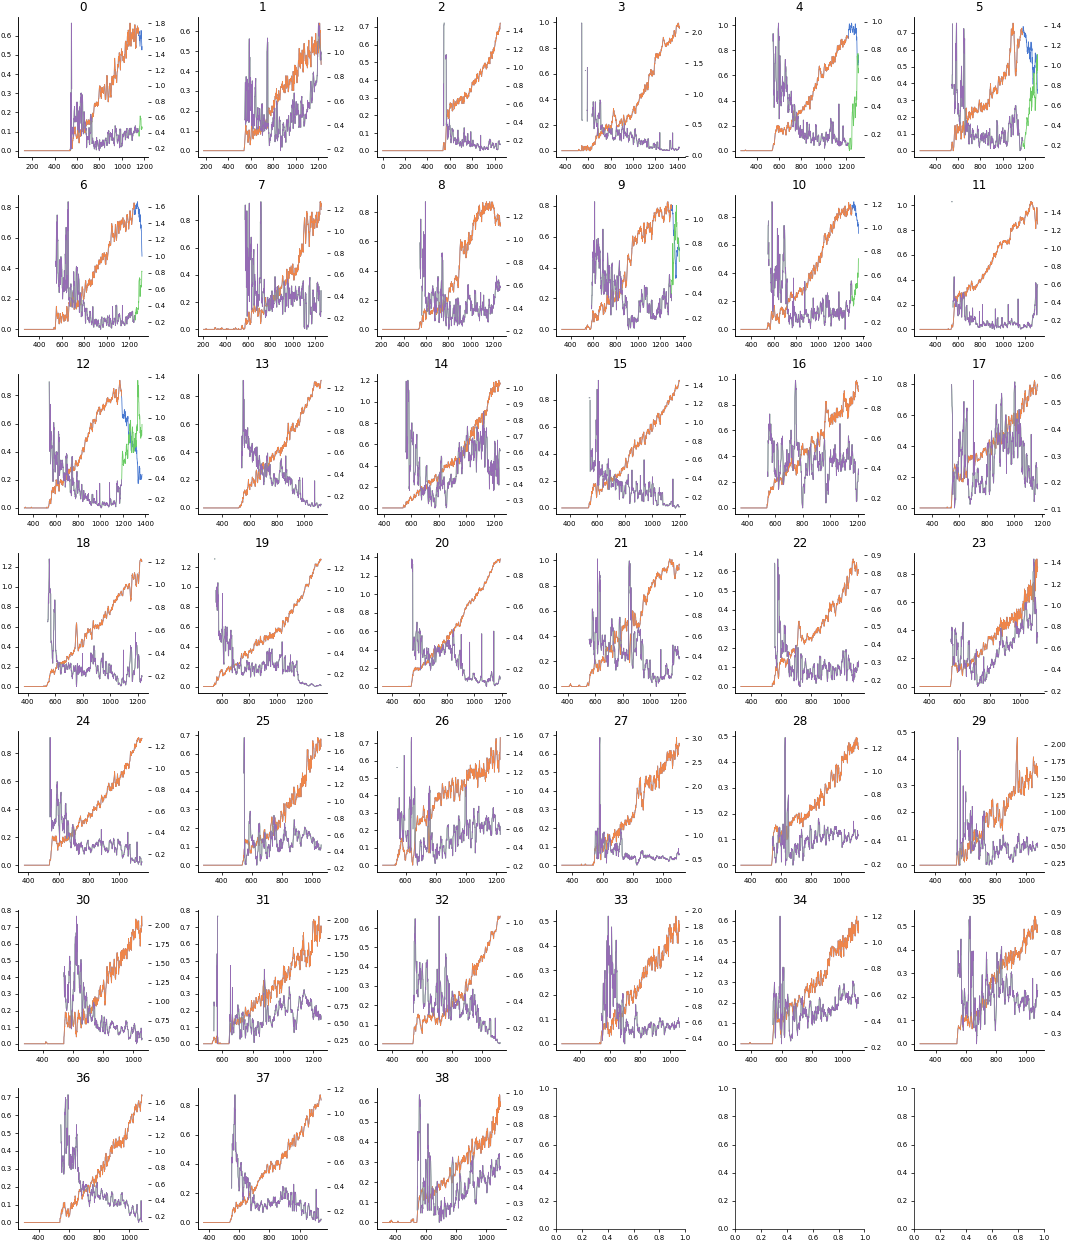

In [8]:
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[0] = 1150
index_cutoffs[4] = 1220
index_cutoffs[5] = 1180
index_cutoffs[6] = 1250
index_cutoffs[9] = 1300
index_cutoffs[10] = 1300
index_cutoffs[11] = 1350
index_cutoffs[12] = 1190

fig1, axes = visualize.tile_plots_conditions(np.arange(aligned_covs.shape[0]), (2.5,2.5))
for i in range(aligned_covs.shape[0]):
    axes[i].set_title("%d" % i)
    axes[i].plot(aligned_frequencies[i,:])
    axes[i].plot(aligned_frequencies[i,:index_cutoffs[i]])
    ax2 = axes[i].twinx()
    ax2.plot(aligned_covs[i,:], color="C2")
    ax2.plot(aligned_covs[i,:index_cutoffs[i]], color="C4")
plt.tight_layout()

In [10]:
for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

### Fit to INaP-IK SNIC

In [11]:
sim_datadir = "/n/holyscratch01/cohen_lab/bjia/20220418_all_bifurcations/"
simulation_results = {}
bifurcations = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]
for bif in bifurcations:
    simulation_results[bif] = np.load(os.path.join(sim_datadir, bif, "results.npz"))

In [213]:
bif = "snic"
cov_sim = simulation_results[bif]["isi_cv"]
f_sim = simulation_results[bif]["freq"]
sigmas = simulation_results[bif]["sigmas"]
rs = simulation_results[bif]["Is"]

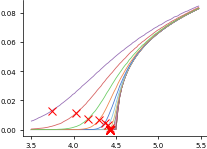

In [214]:
I_offset = 4.5
f_sim_smoothed = signal.savgol_filter(f_sim, 15, 2, axis=1)
g2 = np.gradient(np.gradient(f_sim_smoothed, axis=1), axis=1)
g2[:,rs > I_offset] = 0
max_diff = np.argmax(g2, axis=1)
plt.plot(rs, f_sim.T)
for i in range(f_sim.shape[0]):
    plt.plot(rs[max_diff[i]], f_sim[i,max_diff[i]], "rx")

# plt.xlim(0.6, 1.1)
# plt.ylim(-0.01, 0.4)

In [215]:
rs[max_diff]

array([4.433333, 4.433333, 4.433333, 4.433333, 4.433333, 4.433333,
       4.433333, 4.433333, 4.433333, 4.411111, 4.366667, 4.3     ,
       4.166667, 4.033333, 3.744444])

In [216]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scales = (I_offset - rs[max_diff])/(np.mean(n_valid))

In [225]:
scale_factors = [250,5,2.5]
fit_params = np.load(os.path.join(sim_datadir, "individual_fits_%s.npz" % bif))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']

In [79]:
#including nans
scale_factors = [250,5,2.5]
n_embryos = aligned_frequencies.shape[0]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
errors = {}
for row in range(len(sigmas)):
    try:
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                           540, -I_offset, scale_factors, relweight=1)
        flookup_nm[row] = f_lookup
        covlookup_nm[row] = cov_lookup
        for embryo in range(n_embryos):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]
            bounds_embryo = np.array([[characteristic_scales[row]*scale_factors[0]*3, characteristic_scales[row]*8*scale_factors[0]], \
              [0.35, 0.8], \
              [((rs[max_diff[row]]-I_offset)-0.1)*scale_factors[2], ((rs[max_diff[row]]-I_offset)+0.02)*scale_factors[2]]])
            bounds[embryo,row,:,:] = bounds_embryo
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scales[row]*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=(bounds_embryo[2,0]+bounds_embryo[2,1])/2,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=3000, method="ampgo")
            err_nm[embryo, row] = out.redchi
            beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
    except Exception as e:
        errors[row] = e
        continue
np.savez(os.path.join(sim_datadir, "individual_fits_%s.npz" %bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

In [80]:
fit_params = np.load(os.path.join(sim_datadir, "individual_fits_%s.npz" % bif))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']

[ 0.17182786  0.64201657 -0.45102556]
[[ 0.17182635  0.45820361]
 [ 0.35        0.8       ]
 [-0.75       -0.45      ]]
[ 0.37576256  0.5951149  -0.46027238]
[[ 0.17182635  0.45820361]
 [ 0.35        0.8       ]
 [-0.75       -0.45      ]]
[ 0.44207071  0.43337065 -0.50508606]
[[ 0.17182635  0.45820361]
 [ 0.35        0.8       ]
 [-0.75       -0.45      ]]
[ 0.2072417   0.79380782 -0.53539212]
[[ 0.17182635  0.45820361]
 [ 0.35        0.8       ]
 [-0.75       -0.45      ]]
[ 0.33457223  0.4698026  -0.52577771]
[[ 0.17182635  0.45820361]
 [ 0.35        0.8       ]
 [-0.75       -0.45      ]]


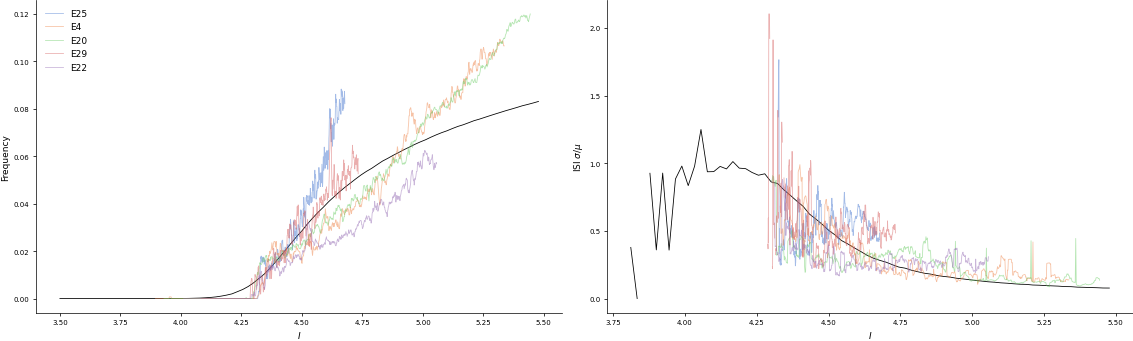

In [226]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 11
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + I_offset

axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
# axes[0].set_xlim((0.8,1.2))
# axes[1].set_xlim((0.8,1.2))
# axes[0].set_ylim((-0.1,0.6))

# axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

In [132]:
fitted_f_interpolation_functions = []
fitted_cv_interpolation_functions = []
for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    
    xdat_f = xvals_data_scaled[e,~np.isnan(f_expt)]
    xdat_cov = xvals_data_scaled[e,~np.isnan(cov_expt)]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(cov_expt)]
    
    fitted_f_interpolation_functions.append(interpolate.interp1d(xdat_f, f_expt_masked*beta_nm[e,row,1]/scale_factors[1],\
                                                fill_value=(f_expt_masked[0]*beta_nm[e,row,1]/scale_factors[1],\
                                                    f_expt_masked[-1]*beta_nm[e,row,1]/scale_factors[1]), bounds_error=False))
    fitted_cv_interpolation_functions.append(interpolate.interp1d(xdat_cov, cov_expt_masked,\
                                                fill_value=(cov_expt_masked[0], cov_expt_masked[-1]), bounds_error=False))

data_disp_range = np.linspace(4, 5, num=100)
all_xs = np.tile(data_disp_range, beta_nm.shape[0])
all_interp_fs = np.array([f(data_disp_range) for f in fitted_f_interpolation_functions])
all_interp_cvs = np.array([f(data_disp_range) for f in fitted_cv_interpolation_functions])

Text(0.5, 0, '$I$')

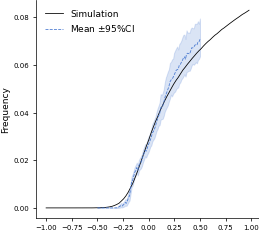

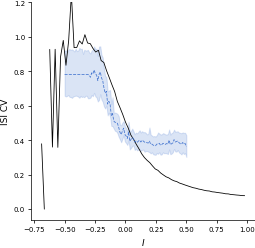

In [133]:
fig1, ax1 = plt.subplots(figsize=(4,4))
fig2, ax2 = plt.subplots(figsize=(4,4))
axes = [ax1, ax2]
display_offset = 4.5

axes[0].plot(rs-display_offset, frequency, color="black", label="Simulation")
axes[1].plot(rs-display_offset, cov, color="black")
# axes[0].set_xlim(-0.35, 0.25)
# axes[1].set_xlim(-0.35, 0.25)

sbs.lineplot(x=all_xs.ravel()-display_offset,\
             y=all_interp_fs.ravel(), ax=axes[0])
axes[0].lines[1].set_linestyle("--")
axes[0].lines[1].set_label(r"Mean $\pm 95\% \mathrm{CI}$")
axes[0].legend()
axes[0].set_ylabel("Frequency")
# axes[0].set_ylim(None, 0.7)

sbs.lineplot(x=all_xs.ravel()-display_offset, \
             y=all_interp_cvs.ravel(), ax=axes[1])


axes[1].lines[1].set_linestyle("--")
axes[1].set_ylim(None, 1.2)
axes[1].set_ylabel(r"ISI CV")
axes[1].set_xlabel(r"$I$")
# axes[1].set_yticks([0, 0.5, 1])


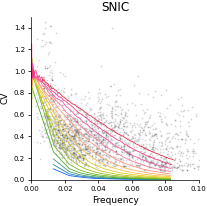

In [228]:
fig1, ax1 = plt.subplots(figsize=(3,3))
all_x = []
all_y = []
row = 11
for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(f_expt)]
    all_x.extend(list(f_expt_masked*beta_nm[e,row,1]/scale_factors[1]))
    all_y.extend(list(cov_expt_masked))
all_x = np.array(all_x)
all_y = np.array(all_y)
n_points = 3000
indices = np.random.choice(len(all_x), n_points, replace=False)
ax1.scatter(all_x[indices], all_y[indices], s=1, alpha=0.1, color="k")
cm_string = "cet_CET_R3"
cmap = cmaps.get_cmap(cm_string)
for r in range(len(sigmas)):
#     ax1.scatter(f[row,:], covs[row,:], s=3, color=cmap(row/len(sigmas)))
    ax1.plot(f_sim[r,:], cov_sim[r,:], color=cmap(r/len(sigmas)))
ax1.set_xlim(0, 0.1)
ax1.set_xlabel("Frequency")
ax1.set_ylabel("CV")
ax1.set_ylim(0, 1.5)
ax1.set_title("SNIC")
plt.savefig(os.path.join(figdir, "Figure5", "Supplements", "frequency_cv_snic.svg"))

In [229]:
bif = "saddle_node"
cov_sim = simulation_results[bif]["isi_cv"]
f_sim = simulation_results[bif]["freq"]
sigmas = simulation_results[bif]["sigmas"]
rs = simulation_results[bif]["Is"]

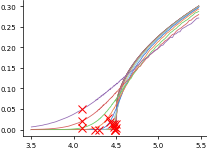

In [230]:
I_offset = 4.5
f_sim_smoothed = signal.savgol_filter(f_sim, 15, 2, axis=1)
g2 = np.gradient(np.gradient(f_sim_smoothed, axis=1), axis=1)
g2[:,rs > I_offset] = 0
max_diff = np.argmax(g2, axis=1)
plt.plot(rs, f_sim.T)
for i in range(f_sim.shape[0]):
    plt.plot(rs[max_diff[i]], f_sim[i,max_diff[i]], "rx")

# plt.xlim(0.6, 1.1)
# plt.ylim(-0.01, 0.4)

In [231]:
rs[max_diff]

array([4.300556, 4.257778, 4.487222, 4.491111, 4.491111, 4.495   ,
       4.495   , 4.475556, 4.475556, 4.452222, 4.428889, 4.409444,
       4.1     , 4.1     , 4.1     ])

In [232]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scales = (I_offset - rs[max_diff])/(np.mean(n_valid))

In [233]:
fit_params = np.load(os.path.join(sim_datadir, "individual_fits_%s.npz" % bif))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']
scale_factors = [250,1,2.5]


In [161]:
#including nans
scale_factors = [250,1,2.5]
n_embryos = aligned_frequencies.shape[0]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
errors = {}
for row in range(len(sigmas)):
    try:
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                           540, -I_offset, scale_factors, relweight=1)
        flookup_nm[row] = f_lookup
        covlookup_nm[row] = cov_lookup
        for embryo in range(n_embryos):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]
            bounds_embryo = np.array([[characteristic_scales[row]*scale_factors[0]*3, characteristic_scales[row]*8*scale_factors[0]], \
              [0.35, 0.8], \
              [((rs[max_diff[row]]-I_offset)-0.1)*scale_factors[2], ((rs[max_diff[row]]-I_offset)+0.02)*scale_factors[2]]])
            bounds[embryo,row,:,:] = bounds_embryo
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scales[row]*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=(bounds_embryo[2,0]+bounds_embryo[2,1])/2,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=3000, method="ampgo")
            err_nm[embryo, row] = out.redchi
            beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
    except Exception as e:
        errors[row] = e
        continue
np.savez(os.path.join(sim_datadir, "individual_fits_%s.npz" %bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

[ 0.16070153  0.3542283  -0.12783924]
[[ 0.06109372  0.16291658]
 [ 0.35        0.8       ]
 [-0.4277775  -0.1277775 ]]
[ 0.10046055  0.63423745 -0.39223944]
[[ 0.06109372  0.16291658]
 [ 0.35        0.8       ]
 [-0.4277775  -0.1277775 ]]
[ 0.16103226  0.35003649 -0.25120807]
[[ 0.06109372  0.16291658]
 [ 0.35        0.8       ]
 [-0.4277775  -0.1277775 ]]
[ 0.11467445  0.39397814 -0.12777752]
[[ 0.06109372  0.16291658]
 [ 0.35        0.8       ]
 [-0.4277775  -0.1277775 ]]
[ 0.16141825  0.43452121 -0.12789119]
[[ 0.06109372  0.16291658]
 [ 0.35        0.8       ]
 [-0.4277775  -0.1277775 ]]


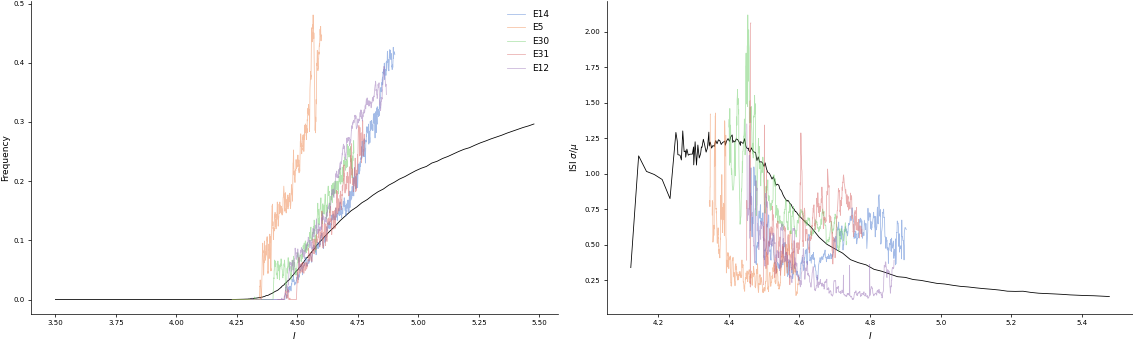

In [163]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 10
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + I_offset

axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
# axes[0].set_xlim((0.8,1.2))
# axes[1].set_xlim((0.8,1.2))
# axes[0].set_ylim((-0.1,0.6))

# axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

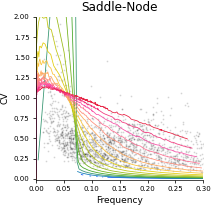

In [234]:
fig1, ax1 = plt.subplots(figsize=(3,3))
all_x = []
all_y = []

for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(f_expt)]
    all_x.extend(list(f_expt_masked*beta_nm[e,row,1]/scale_factors[1]))
    all_y.extend(list(cov_expt_masked))
all_x = np.array(all_x)
all_y = np.array(all_y)
n_points = 3000
indices = np.random.choice(len(all_x), n_points, replace=False)
ax1.scatter(all_x[indices], all_y[indices], s=1, alpha=0.1, color="k")
cm_string = "cet_CET_R3"
cmap = cmaps.get_cmap(cm_string)
for r in range(len(sigmas)):
#     ax1.scatter(f[row,:], covs[row,:], s=3, color=cmap(row/len(sigmas)))
    ax1.plot(f_sim[r,:], cov_sim[r,:], color=cmap(r/len(sigmas)))
ax1.set_xlim(0, 0.3)
ax1.set_ylim(-0.01, 2)
ax1.set_xlabel("Frequency")
ax1.set_ylabel("CV")
ax1.set_title("Saddle-Node")
plt.savefig(os.path.join(figdir, "Figure5", "Supplements", "frequency_cv_saddle_node.svg"))

In [239]:
bif = "supercritical_hopf"
cov_sim = simulation_results[bif]["isi_cv"]
f_sim = simulation_results[bif]["freq"]
sigmas = simulation_results[bif]["sigmas"]
rs = simulation_results[bif]["Is"]

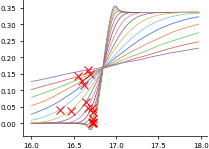

In [240]:
I_offset = 16.9
f_sim_smoothed = signal.savgol_filter(f_sim, 17, 2, axis=1)
g2 = np.gradient(np.gradient(f_sim_smoothed, axis=1), axis=1)
g2[:,rs > I_offset] = 0
max_diff = np.argmax(g2, axis=1)
plt.plot(rs, f_sim_smoothed.T)
for i in range(f_sim.shape[0]):
    plt.plot(rs[max_diff[i]], f_sim[i,max_diff[i]], "rx")

# plt.xlim(0.6, 1.1)
# plt.ylim(-0.01, 0.4)

In [241]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scales = (I_offset - rs[max_diff])/(np.mean(n_valid))
fit_params = np.load(os.path.join(sim_datadir, "individual_fits_%s.npz" % bif))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']
scale_factors = [250,1,2.5]

In [178]:
#including nans
scale_factors = [250,1,2.5]
n_embryos = aligned_frequencies.shape[0]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
errors = {}
for row in range(len(sigmas)):
    try:
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                           540, -I_offset, scale_factors, relweight=1)
        flookup_nm[row] = f_lookup
        covlookup_nm[row] = cov_lookup
        for embryo in range(n_embryos):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]
            bounds_embryo = np.array([[characteristic_scales[row]*scale_factors[0]*3, characteristic_scales[row]*8*scale_factors[0]], \
              [0.35, 0.8], \
              [((rs[max_diff[row]]-I_offset)-0.1)*scale_factors[2], ((rs[max_diff[row]]-I_offset)+0.02)*scale_factors[2]]])
            bounds[embryo,row,:,:] = bounds_embryo
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scales[row]*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=(bounds_embryo[2,0]+bounds_embryo[2,1])/2,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=3000, method="ampgo")
            err_nm[embryo, row] = out.redchi
            beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
    except Exception as e:
        errors[row] = e
        continue
np.savez(os.path.join(sim_datadir, "individual_fits_%s.npz" %bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

[ 0.37751039  0.52297992 -0.5907849 ]
[[ 0.21955628  0.5854834 ]
 [ 0.35        0.8       ]
 [-0.88889    -0.58889   ]]
[ 0.5505964   0.5391885  -0.83305273]
[[ 0.21955628  0.5854834 ]
 [ 0.35        0.8       ]
 [-0.88889    -0.58889   ]]
[ 0.5854808   0.70682848 -0.58889007]
[[ 0.21955628  0.5854834 ]
 [ 0.35        0.8       ]
 [-0.88889    -0.58889   ]]
[ 0.24831584  0.77621765 -0.58937356]
[[ 0.21955628  0.5854834 ]
 [ 0.35        0.8       ]
 [-0.88889    -0.58889   ]]
[ 0.2282997   0.56812246 -0.58942348]
[[ 0.21955628  0.5854834 ]
 [ 0.35        0.8       ]
 [-0.88889    -0.58889   ]]


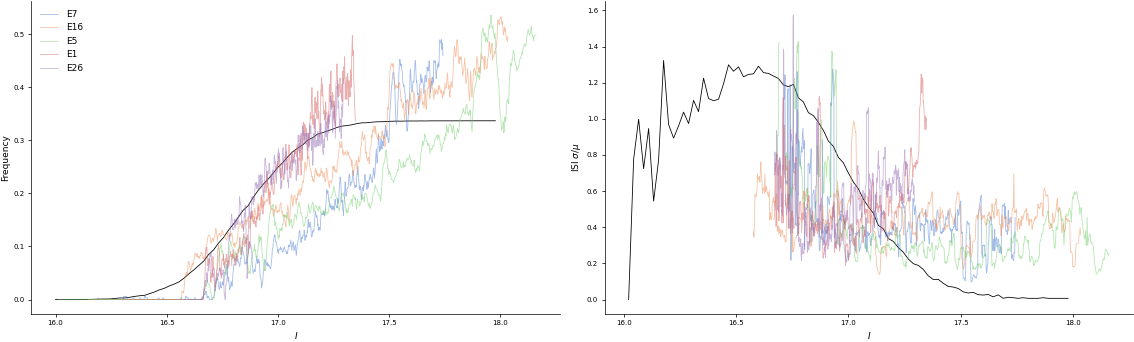

In [244]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 7
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + I_offset

axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
# axes[0].set_xlim((0.8,1.2))
# axes[1].set_xlim((0.8,1.2))
# axes[0].set_ylim((-0.1,0.6))

# axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

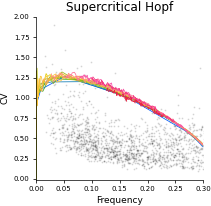

In [247]:
fig1, ax1 = plt.subplots(figsize=(3,3))
all_x = []
all_y = []

for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(f_expt)]
    all_x.extend(list(f_expt_masked*beta_nm[e,row,1]/scale_factors[1]))
    all_y.extend(list(cov_expt_masked))
all_x = np.array(all_x)
all_y = np.array(all_y)
n_points = 3000
indices = np.random.choice(len(all_x), n_points, replace=False)
ax1.scatter(all_x[indices], all_y[indices], s=1, alpha=0.1, color="k")
cm_string = "cet_CET_R3"
cmap = cmaps.get_cmap(cm_string)
for r in range(len(sigmas)):
#     ax1.scatter(f[row,:], covs[row,:], s=3, color=cmap(row/len(sigmas)))
    ax1.plot(f_sim[r,:], cov_sim[r,:], color=cmap(r/len(sigmas)))
ax1.set_xlim(0, 0.3)
ax1.set_ylim(-0.01, 2)
ax1.set_xlabel("Frequency")
ax1.set_ylabel("CV")
ax1.set_title("Supercritical Hopf")
plt.savefig(os.path.join(figdir, "Figure5", "Supplements", "frequency_cv_supercritical_hopf.svg"))

In [248]:
bif = "subcritical_hopf"
cov_sim = simulation_results[bif]["isi_cv"]
f_sim = simulation_results[bif]["freq"]
sigmas = simulation_results[bif]["sigmas"]
rs = simulation_results[bif]["Is"]

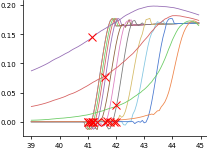

In [249]:
I_offset = 42
f_sim_smoothed = signal.savgol_filter(f_sim, 17, 2, axis=1)
g2 = np.gradient(np.gradient(f_sim_smoothed, axis=1), axis=1)
g2[:,rs > I_offset] = 0
max_diff = np.argmax(g2, axis=1)
plt.plot(rs, f_sim_smoothed.T)
for i in range(f_sim.shape[0]):
    plt.plot(rs[max_diff[i]], f_sim[i,max_diff[i]], "rx")

# plt.xlim(0.6, 1.1)
# plt.ylim(-0.01, 0.4)

In [250]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scales = (I_offset - rs[max_diff])/(np.mean(n_valid))
fit_params = np.load(os.path.join(sim_datadir, "individual_fits_%s.npz" % bif))
beta_nm = fit_params['beta_nm']
bounds =  fit_params['bounds']
scale_factors = [100,1,1]

In [251]:
#including nans
scale_factors = [100,1,1]
n_embryos = aligned_frequencies.shape[0]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
errors = {}
for row in range(len(sigmas)):
    try:
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                           540, -I_offset, scale_factors, relweight=1)
        flookup_nm[row] = f_lookup
        covlookup_nm[row] = cov_lookup
        for embryo in range(n_embryos):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]
            bounds_embryo = np.array([[characteristic_scales[row]*scale_factors[0]*3, characteristic_scales[row]*8*scale_factors[0]], \
              [0.35, 0.8], \
              [((rs[max_diff[row]]-I_offset)-0.2)*scale_factors[2], ((rs[max_diff[row]]-I_offset)+2)*scale_factors[2]]])
            bounds[embryo,row,:,:] = bounds_embryo
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scales[row]*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=(bounds_embryo[2,0]+bounds_embryo[2,1])/2,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=3000, method="ampgo")
            err_nm[embryo, row] = out.redchi
            beta_nm[embryo, row, :] = [out.params['x_scale'].value, out.params['amplitude'].value, out.params['x_offset'].value]
    except Exception as e:
        errors[row] = e
        continue
np.savez(os.path.join(sim_datadir, "individual_fits_%s.npz" %bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

[ 0.0812828   0.35000014 -0.3967487 ]
[[ 0.06873054  0.18328144]
 [ 0.35        0.8       ]
 [-0.4         1.8       ]]
[0.06929458 0.35008328 0.07017402]
[[ 0.06873054  0.18328144]
 [ 0.35        0.8       ]
 [-0.4         1.8       ]]
[0.06994024 0.35001177 0.04936712]
[[ 0.06873054  0.18328144]
 [ 0.35        0.8       ]
 [-0.4         1.8       ]]
[0.10581011 0.35120767 0.03831334]
[[ 0.06873054  0.18328144]
 [ 0.35        0.8       ]
 [-0.4         1.8       ]]
[0.07462029 0.35069341 0.03646265]
[[ 0.06873054  0.18328144]
 [ 0.35        0.8       ]
 [-0.4         1.8       ]]


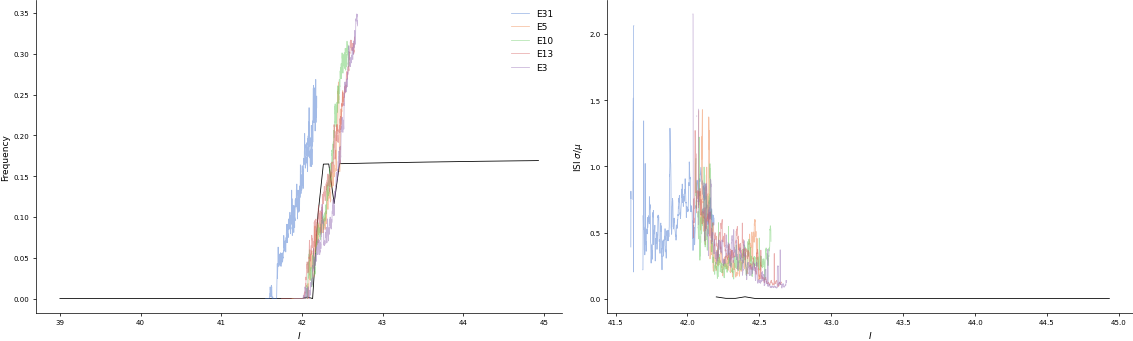

In [256]:
fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes = axes.ravel()
row = 7
frequency = f_sim[row,:]
cov = cov_sim[row,:]
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + I_offset

axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")

sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
for e in sorted_indices:
    print(beta_nm[e,row,:])
    print(bounds[e,row,:,:])
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
    axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
# axes[0].set_xlim((0.8,1.2))
# axes[1].set_xlim((0.8,1.2))
# axes[0].set_ylim((-0.1,0.6))

# axes[1].set_ylim((-0.1, 1.2))
plt.tight_layout()

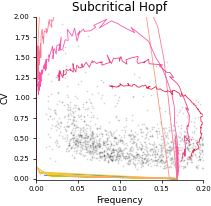

In [257]:
fig1, ax1 = plt.subplots(figsize=(3,3))
all_x = []
all_y = []

for e in range(aligned_frequencies.shape[0]):
    f_expt = aligned_frequencies[e,:]
    cov_expt = aligned_covs[e,:]
    f_expt_masked = f_expt[~np.isnan(f_expt)]
    cov_expt_masked = cov_expt[~np.isnan(f_expt)]
    all_x.extend(list(f_expt_masked*beta_nm[e,row,1]/scale_factors[1]))
    all_y.extend(list(cov_expt_masked))
all_x = np.array(all_x)
all_y = np.array(all_y)
n_points = 3000
indices = np.random.choice(len(all_x), n_points, replace=False)
ax1.scatter(all_x[indices], all_y[indices], s=1, alpha=0.1, color="k")
cm_string = "cet_CET_R3"
cmap = cmaps.get_cmap(cm_string)
for r in range(len(sigmas)):
#     ax1.scatter(f[row,:], covs[row,:], s=3, color=cmap(row/len(sigmas)))
    ax1.plot(f_sim[r,:], cov_sim[r,:], color=cmap(r/len(sigmas)))
ax1.set_xlim(0, 0.2)
ax1.set_ylim(-0.01, 2)
ax1.set_title("Subcritical Hopf")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("CV")
plt.savefig(os.path.join(figdir, "Figure5", "Supplements", "frequency_cv_subcritical_hopf.svg"))